这是Tensorflow对于回归问题（regression problem）的官方教程，个人感觉代码写的干净漂亮，不仅仅可以学到回归问题的解决方法，也可以学到诸如数据准备、结果展示等技术，因此详细的剖析了这个教程，加上了我个人认为需要补充的资料背景。

本教程通过[Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)这个数据集构建了一个模型来预测70年代晚期和80年代早期的汽车燃油经济性，即通常所说的百公里油耗（MPG的本意是Miles Per Gallon）。关于这个数据集的内容，在下面的分析中会给出其结构。

这个教程既可以运行于Tensorflow 1.x版本，也可以运行于Tensorflow 2.x版本，本人亲测。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0-beta1


# Auto MPG数据集

Auto MPG数据集是[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/)的476个数据集之一，包含了398条记录，结构如下：

1. mpg: 百公里油耗
2. cylinders: 气缸数
3. displacement: 排气量
4. horsepower: 马力
5. weight: 车重 
6. acceleration: 加速能力
7. model year: 年份
8. origin: 原产地
9. car name: 车型名称



## 下载数据集
keras提供了几种下载数据的方式，一种是直接使用keras中已经包含了的数据集，比如mnist数据集。一种是如下的方式下载数据：

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/subaochen/.keras/datasets/auto-mpg.data'

使用pandas处理Auto MPG数据集。Auto MPG本质上是csv格式的，因此pandas可以直接打开。由于"car name"这一列和MPG并没有关系，因此在实际读取数据集的时候通过column_names限定了用到的数据列。

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 清理数据（缺失值）

这个数据集中有几条没有数据的记录，需要清理掉。通常，新拿到一个数据集，都需要检测数据集是否存在无效记录。

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

使用dropna从数据集中删除无效记录。

In [5]:
dataset = dataset.dropna()

`"Origin"`这个字段需要转换为one-hot编码。这是一种常见的技巧，将类别数字转化为one-hot编码，以便机器学习到原产地对于MPG的影响。如果不进行one-hot编码，`Origin`是用1,2,3等数字来表示的，直接这样使用的话机器学习会把`Origin`当做一个数量而不是**类别**来对待，这显然不是我们的本意。

这里处理`Origin`字段的方法值得注意：`pop`弹出这一列，然后根据`pop`字段的值重新增加三个列。

In [6]:
origin = dataset.pop('Origin')

In [7]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 切分训练数据集和测试数据集

这里切分数据集的方法很巧妙，使用了`DataFrame`的`sample`方法，一次性完成了随机选取，也避免了`shuffle`操作，至少是简洁的做法，是否高效未可知。

测试数据集的获得也很巧妙，直接从原始数据集中`drop`掉训练数据集即可。

另外常见的切分数据集的方法是sklearn的train_test_split函数，比如：

```
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, train_size=0.8, test_size=0.2, shuffle=True)
```

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## 查看训练数据集

seaborn的pairplot提供了图形化的方式快速查看数据集，更高效直观，这里使用pairplot来表现两两的特征对比图。比如：

* 从右上角的图可以看出，车子越重，燃油的经济性越低（百公里油耗越高，即每加仑行驶的里程越少）
* 从第一行第二列可以看出，气缸数越多，燃油经济型越低。
* 同样的，排气量大的车子，燃油经济性也越差。

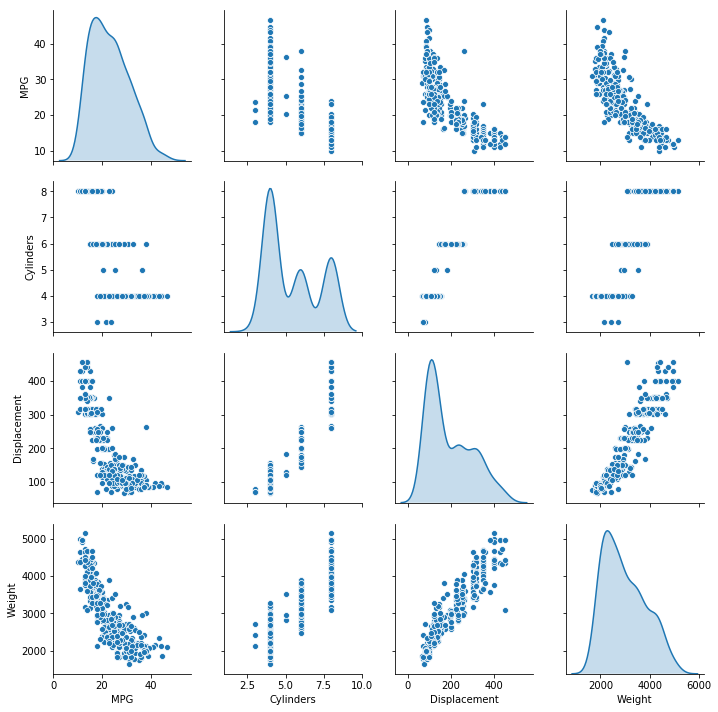

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

看一下训练集的统计数据，这个统计数据在后面进行数据的标准化的时候会用到。

In [10]:
train_stats = train_dataset.describe()
# 不剔除MPG这一列也没有关系，只不过没有使用而已
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 获得标签数据集

标签（label）是训练模型的“指导”或者“准星”，根据label训练模型的目的就是在预测时，能够尽量逼近label。这里直接将train_dataset/test_dataset中的MPG列pop出来即可。

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 数据的标准化处理

关于为什么要对数据进行标准化处理，数据标准化处理有哪几种方式，感觉这几篇讲的还不错，值得参考：
* [ML入门：归一化、标准化、正则化](https://zhuanlan.zhihu.com/p/29957294)
* [归一化和标准化大全](https://www.jianshu.com/p/c1e112f3f57f)

什么时候使用标准化，什么时候使用归一化？由于归一化是一维伸缩，标准化二维伸缩，所以基本上如果数据没有太大的噪声可以考虑归一化，处理起来比较简单，如果噪声多可以考虑标准化。下面这张图可以形象的看出标准化的过程(出处见上面第一个链接)，先减去均值，然后再除以标准差：

![数据的标准化过程](https://raw.githubusercontent.com/subaochen/subaochen.github.io/master/images/tensorflow/data-normalization.jpg)


除了这里的数据标准化方法之外，sklean中已经提供了成熟的数据标准化、归一化的函数，比如：
```
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
# 标准化
normed_train_dataset = scaler.fit_transform(train_dataset)
# 归一化
mm_train_dataset = MinMaxScaler().fit_transform(train_dataset) 
```

这里自己写了一个norm方法，目的是为了能够演示标准化的步骤，也能够直接使用已经获得统计数据。

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data[:5])

     Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
146  -0.869348     -1.009459   -0.784052 -1.025303     -0.379759   -0.516397   
282  -0.869348     -0.530218   -0.442811 -0.118796      0.624102    0.843910   
69    1.483887      1.482595    1.447140  1.736877     -0.738281   -1.060519   
378  -0.869348     -0.865687   -1.099044 -1.025303     -0.308055    1.660094   
331  -0.869348     -0.942365   -0.994047 -1.001603      0.875068    1.115971   

          USA    Europe     Japan  
146  0.774676 -0.465148 -0.495225  
282  0.774676 -0.465148 -0.495225  
69   0.774676 -0.465148 -0.495225  
378  0.774676 -0.465148 -0.495225  
331 -1.286751 -0.465148  2.012852  


需要特别两点：

* 当对数据进行了标准操作的时候，所有喂入网络的数据必须根据同一个scaler对象进行标准化操作，即便是one-hot编码的数据也要做标准化处理。这很容易理解：只有数据同步缩放才能消除比较”突出“的数据。
* 测试数据集以及将来进行预测的其他数据也要进行同样的标准化处理。

# 模型

## 构建模型

这里使用了高阶的keras API构建模型，这是目前主流的模型构建方法。在这个简单的模型中只包含了两个全连接隐藏层和一个全连接输出层，其中我们的输入层的shape为(len(train_dataset.keys()),)，第一个全连接层的输出shape为(None, 64)，第二个全连接层的输出为(None, 64)。其中，None的大小由BATCH_SIZE决定。

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [14]:
model = build_model()

## 查看模型的结构

`.summary`函数可以打印出模型的简单描述：

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


先尝试运行一下模型。这里取批次（batch）大小为10，先喂入10组数据看看结果如何：`model.predict`给出了预测的结果，shape为(10,1)，符合模型的定义。

In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.33291826],
       [ 0.20068091],
       [-0.2432324 ],
       [ 0.2772663 ],
       [ 0.25557014],
       [ 0.05211536],
       [ 0.28773528],
       [ 0.38458073],
       [ 0.04117467],
       [ 0.15005343]], dtype=float32)

## 训练模型

这里定义的训练轮次（epochs）为1000。训练和验证的准确率记录在`history`中了，方便通过图形化显示准确率的变动情况。

注意fit函数的参数validation_split，表示将训练数据自动拿出指定比例的数据作为验证数据集，验证数据集是不参与训练的。因此，使用了validation_split还是很方便的一种手段，不需要手工准备验证数据集。

In [17]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

图形化展示`history`对象中存储的训练过程。

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.856708,1.074385,2.856708,8.499714,2.212823,8.499714,995
996,2.816071,1.094623,2.816071,8.883725,2.365754,8.883725,996
997,2.852280,1.078358,2.852280,8.369126,2.132020,8.369126,997
998,2.754595,1.063068,2.754595,8.362683,2.193305,8.362682,998
999,2.606283,1.027212,2.606283,8.404507,2.265347,8.404507,999


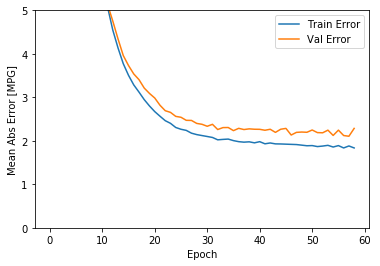

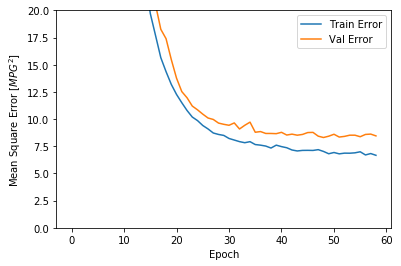

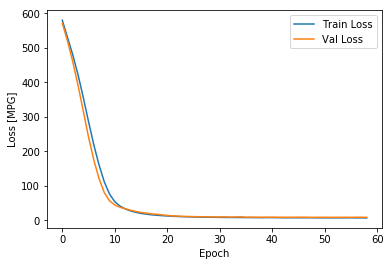

In [24]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

  # loss
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss [MPG]')
  plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
  plt.legend()
  plt.show()


plot_history(history)

上面的图形显示，训练轮次达到100以后，验证误差不再降低，甚至有些抬升，这意味着继续训练没有益处（过拟合）。Tensorflow提供了EarlyStopping技术可以在验证误差（或者其他指定的指标）不再继续“改进”时停止训练，具体可以参考我的另外一篇博客：[Tensorflow的EarlyStopping技术](https://subaochen.github.io/tensorflow/2019/07/21/tensorflow-earlystopping/)。

官方的EarlyStopping介绍在 [这里](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


....................................................

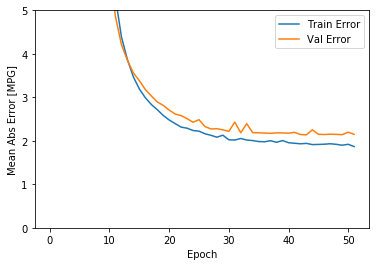

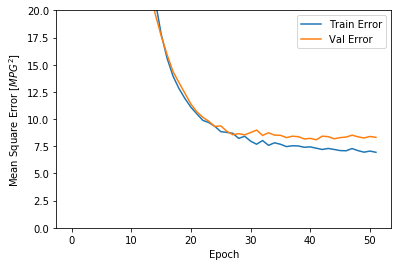

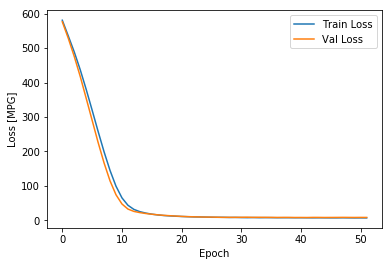

In [25]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

从上图可以看出，在验证数据集上，平均误差大概在+/-2 MPG。这个误差范围是好还是不好呢？如果平均的MPG是20左右，则误差大概有10%了。平均的MPG可以由统计数据给出。

下面看一下在测试数据集上模型的表现如何？通常，把在测试数据集上的表现称为模型的“泛化能力”。可以看出，在测试数据集上的表现和验证数据集上是差不多的，训练的这个模型的泛化能力还不错。

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.84 MPG


## 进行预测

用测试数据集进行预测，看一下预测的准确率如何？预测的方法是使用测试数据集调用模型的`predict`方法，将预测结果和测试数据集的label集合对比，即可以看出预测的效果了。这里采取的方法是，将测试集的label和预测值构造为一个（x,y）点显示在二维坐标上，于是所有的(x,y)如果集中在45度角的直线附近的话，证明预测的准确率比较高。

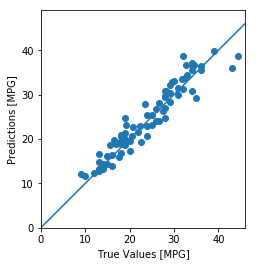

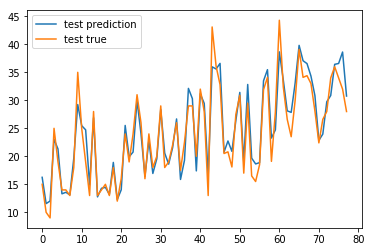

In [44]:
test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
#plt.axis('equal')
plt.axis('square') # 正方形，即ｘ轴和ｙ轴比例相同
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 100], [0, 100]) # 参考的对角线
plt.show()

plt.plot(test_predictions,label='test prediction')
plt.plot(test_labels.values,label='test true')
plt.legend()
plt.show()


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

下面看一下误差的分布情况：

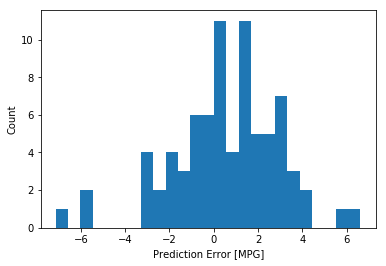

In [54]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()

理想情况下，误差应该符合正态分布，这里看起来不太正态，和样本的数量少有一定关系。

# 结论

这里演示了解决回归问题的一些技术要点：

* Mean Squared Error (MSE) 是回归问题中常见的损失函数，分类问题通常使用交叉熵作为损失函数，这些在Tensorflow中都有预定义。
* 评估回归问题的常用指标是Mean Absolute Error (MAE)。
* 当输入数据的范围相差比较大时，需要对数据进行标准化处理。
* 当训练数据比较少时，相应的网络层次和节点数要减少，以避免过拟合。
* 早停（EarlyStopping）技术可以有效的阻止过拟合。